# Machine Learning Engineer Nanodegree
## Capstone Project
## Predicting Ames Houses

The ultimate goal of this project is to predict how much a house should be solved in Ames, IA.
The problem is a standing [Kaggle Competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques). The dataset contains a list of information for all houses sold in Ames, Iowa from 2006 through 2010. It contains **2930** observations and a large number of explanatory
variables (**23 nominal, 23 ordinal, 14 discrete, and 20 continuous**). Dean De Cook compiled and published this dataset in 2011 and can be found here [here](http://www.amstat.org/publications/jse/v19n3/decock.pdf). 


#### As discussed in the paper, the data is split into training and testing sets. Therefore, in the spirit of the Kaggle competition, I will work on the formats that have been processed and randomly split into 50-50 portions. The test portion is for Kaggle use. No information on SalePrice is made available. So for this development analysis, I will create the models based on the provided train.csv.

### <center> Exploratory Section </center></font>

In [138]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style("whitegrid")
sns.set(font_scale=1.5) 


# Pretty display for notebooks
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.gridspec as grd
import matplotlib.ticker as tkr
import matplotlib.font_manager as font_manager

from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import FuncFormatter
from matplotlib import rcParams

#define plotter
minorLocatorx   = AutoMinorLocator(10)
minorLocatory   = AutoMinorLocator(4)
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16) 
matplotlib.rcParams['axes.linewidth'] = 2.
plt.rcParams['axes.linewidth'] = 4
plt.rc('font', family='serif')
plt.rc('font', serif='Times New Roman') 
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

# Load the Ames housing dataset. This will have to be split for evaluation!
data = pd.read_csv('train.csv')

# If submitting to Kaggle, load the data required to test predictions.
#data_test = pd.read_csv('test.csv')

# Success
print "Boston housing dataset has {} data points with {} variables each.".format(*data.shape)
print data.keys()

Boston housing dataset has 1460 data points with 81 variables each.
Index([u'Id', u'MSSubClass', u'MSZoning', u'LotFrontage', u'LotArea',
       u'Street', u'Alley', u'LotShape', u'LandContour', u'Utilities',
       u'LotConfig', u'LandSlope', u'Neighborhood', u'Condition1',
       u'Condition2', u'BldgType', u'HouseStyle', u'OverallQual',
       u'OverallCond', u'YearBuilt', u'YearRemodAdd', u'RoofStyle',
       u'RoofMatl', u'Exterior1st', u'Exterior2nd', u'MasVnrType',
       u'MasVnrArea', u'ExterQual', u'ExterCond', u'Foundation', u'BsmtQual',
       u'BsmtCond', u'BsmtExposure', u'BsmtFinType1', u'BsmtFinSF1',
       u'BsmtFinType2', u'BsmtFinSF2', u'BsmtUnfSF', u'TotalBsmtSF',
       u'Heating', u'HeatingQC', u'CentralAir', u'Electrical', u'1stFlrSF',
       u'2ndFlrSF', u'LowQualFinSF', u'GrLivArea', u'BsmtFullBath',
       u'BsmtHalfBath', u'FullBath', u'HalfBath', u'BedroomAbvGr',
       u'KitchenAbvGr', u'KitchenQual', u'TotRmsAbvGrd', u'Functional',
       u'Fireplaces', u'

### This dataset has a LOT of features. The first goal of this analysis is to DIMENSIONALITY REDUCTION. We will select only the most relevant features. PCA is seen to be useful But prior to anything technical, we will visualize the natural trends in the data. So we have some intuition for any result further down the road.
### <center> Let's start simple. What are the statistical properties of the selling price? </center></font>

In [2]:
# Minimum price of the data
minimum_price = np.min(data.SalePrice)

# Maximum price of the data
maximum_price = np.max(data.SalePrice)

# Mean price of the data
mean_price = np.mean(data.SalePrice)

# Median price of the data
median_price = np.median(data.SalePrice)

# Standard deviation of prices of the data
std_price = np.std(data.SalePrice)

# Show the calculated statistics
print "Statistics for Boston housing dataset:\n"
print "Minimum price: ${:,.2f}".format(minimum_price)
print "Maximum price: ${:,.2f}".format(maximum_price)
print "Mean price: ${:,.2f}".format(mean_price)
print "Median price ${:,.2f}".format(median_price)
print "Standard deviation of prices: ${:,.2f}".format(std_price)

Statistics for Boston housing dataset:

Minimum price: $34,900.00
Maximum price: $755,000.00
Mean price: $180,921.20
Median price $163,000.00
Standard deviation of prices: $79,415.29


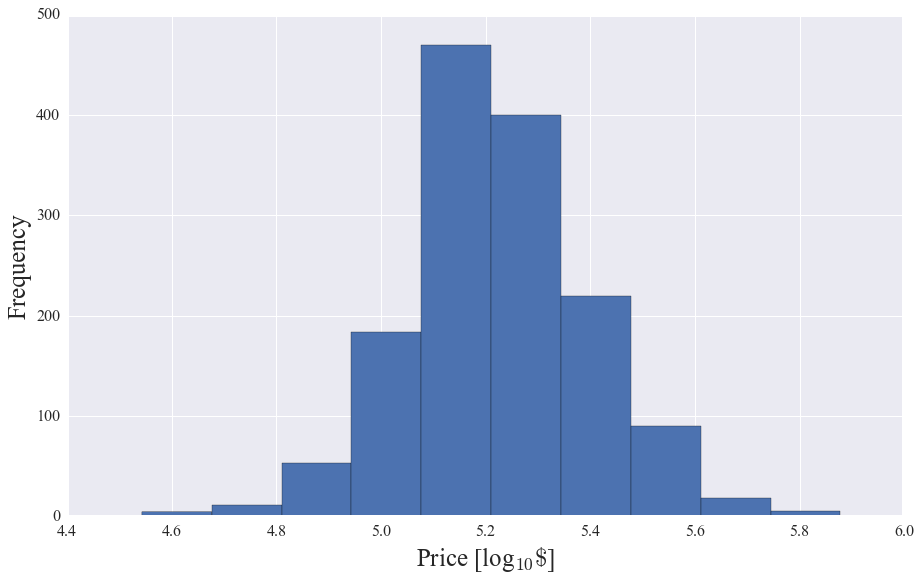

In [9]:
## Let us visualize these results.
log_price = np.log10(data.SalePrice)
plt.hist(log_price)
plt.xlabel('Price '+ r'[log$_{10} \$$]', fontsize = 25)
plt.ylabel('Frequency', fontsize = 25)

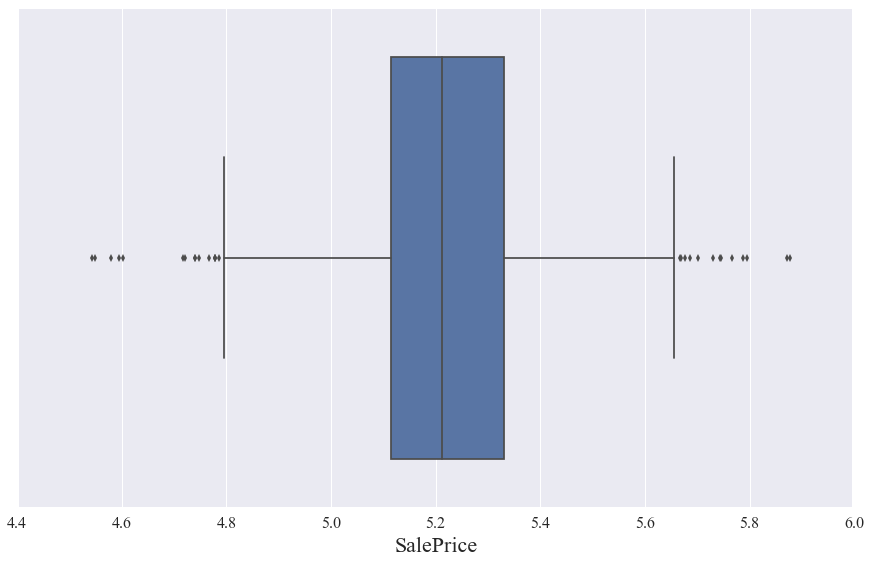

In [10]:
# Box plot: How many outliers are there?
ax = sns.boxplot(x = log_price)

In [37]:
# How many outliers?
# Calculate Q1 (25th percentile of the data) for the given feature
Q1 = np.percentile(log_price, 25)
# Calculate Q3 (75th percentile of the data) for the given feature
Q3 = np.percentile(log_price, 75)
step = 1.5*(Q3-Q1)
print "There are this {} outliers out of a total of {} entries.".format(
    len(log_price[(log_price < Q1 - step)  | (log_price > Q3+step)]), len(data))

There are this 28 outliers out of a total of 1460 entries.


#### Using [Tukey's Method for identfying outliers](http://datapigtechnologies.com/blog/index.php/highlighting-outliers-in-your-data-with-the-tukey-method/): An *outlier step* is calculated as 1.5 times the interquartile range (IQR). A data point with a feature that is beyond an outlier step outside of the IQR for that feature is considered abnormal. 

#### Thus, we will remove all these outliers for a more robust regression analysis.

In [110]:
data_clean = data[(log_price >= Q1 - step)  & (log_price <= Q3+step)]
print "Now we will work on a dataset of {} examples".format(len(data_clean))
data_clean.head()


Now we will work on a dataset of 1432 examples


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### <center> We want to separate the features from the target variable. </center></font>

In [111]:
# Extract feature columns
feature_cols = list(data_clean.columns[1:-1]) # Removed ID columns

# Extract target column 'SalePrice'
target_col = data_clean.columns[-1] 

# Show the list of columns
print "Feature columns:\n{}".format(feature_cols)
print "\nTarget column: {}".format(target_col)

# Separate the data into feature data and target data (X_all and y_all, respectively)
X_all = data_clean[feature_cols]
y_all = data_clean[target_col]

# Show the feature information by printing the first five rows
print "\nFeature values:"
print X_all.head()

Feature columns:
['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea

### <center> We need to convert categorical and non-numeric data appropriately. </center></font>

### Preprocess Feature Columns

There are several non-numeric columns that need to be converted! Some of them are simply are of an **either-or** type. These can be reasonably converted into `1`/`0` (binary) values.

Other columns, like `Alley` and `Street`, have more than two values, and are known as _categorical variables_. The recommended way to handle such a column is to create as many columns as possible values and assign a `1` to one of them and `0` to all others.

These generated columns are sometimes called _dummy variables_, and we will use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation. 
The code cell below to perform the preprocessing routine discussed in this section.

In [132]:
def preprocess_features(X):
    ''' Preprocesses the housing data and converts non-numeric binary variables into
        binary (0/1) variables. Converts categorical variables into dummy variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():

        # If data type is non-numeric, replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])

        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix = col)  
        
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

X_all = preprocess_features(X_all)
#print "Processed feature columns ({} total features):\n{}".format(len(X_all.columns), list(X_all.columns))

In [113]:
X_all.head()

,MSSubClass,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotFrontage,LotArea,Street_Grvl,Street_Pave,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,0.0,0.0,0.0,1.0,0.0,65.0,8450,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,20,0.0,0.0,0.0,1.0,0.0,80.0,9600,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,60,0.0,0.0,0.0,1.0,0.0,68.0,11250,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,70,0.0,0.0,0.0,1.0,0.0,60.0,9550,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,60,0.0,0.0,0.0,1.0,0.0,84.0,14260,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [232]:
## Extract all continuous variables
feature_continuous = []
for feature in X_all.columns:
    if max(X_all[feature]) > 500:
        feature_continuous.append(feature)
data_continuous =  pd.DataFrame(X_all, columns=feature_continuous)
data_continuous.LotArea = np.log10(data_continuous.LotArea)
#Combine the Year Built and the year sold into an Age.
data_continuous['Age'] = data_continuous.YrSold - data_continuous.YearBuilt 
data_continuous['Age_garage'] = data_continuous.YrSold - data_continuous.GarageYrBlt 
data_continuous['Remod_Age'] = data_continuous.YrSold - data_continuous.YearRemodAdd 
#data_continuous['Avg_Age'] = np.sqrt(data_continuous.Age**2+data_continuous.Remod_Age**2)
data_continuous['SalePrice'] = np.log10(y_all)
data_continuous =data_continuous.drop(['YearBuilt', 'YrSold', 
                                       'YearRemodAdd', 'LowQualFinSF', 'GarageYrBlt',
                                       'MiscVal', 'BsmtFinSF1', 'BsmtFinSF2'], axis=1)

data_continuous.columns

Index([u'LotArea', u'MasVnrArea', u'BsmtUnfSF', u'TotalBsmtSF', u'1stFlrSF',
       u'2ndFlrSF', u'GrLivArea', u'GarageArea', u'WoodDeckSF', u'OpenPorchSF',
       u'EnclosedPorch', u'3SsnPorch', u'PoolArea', u'Age', u'Age_garage',
       u'Remod_Age', u'SalePrice'],
      dtype='object')

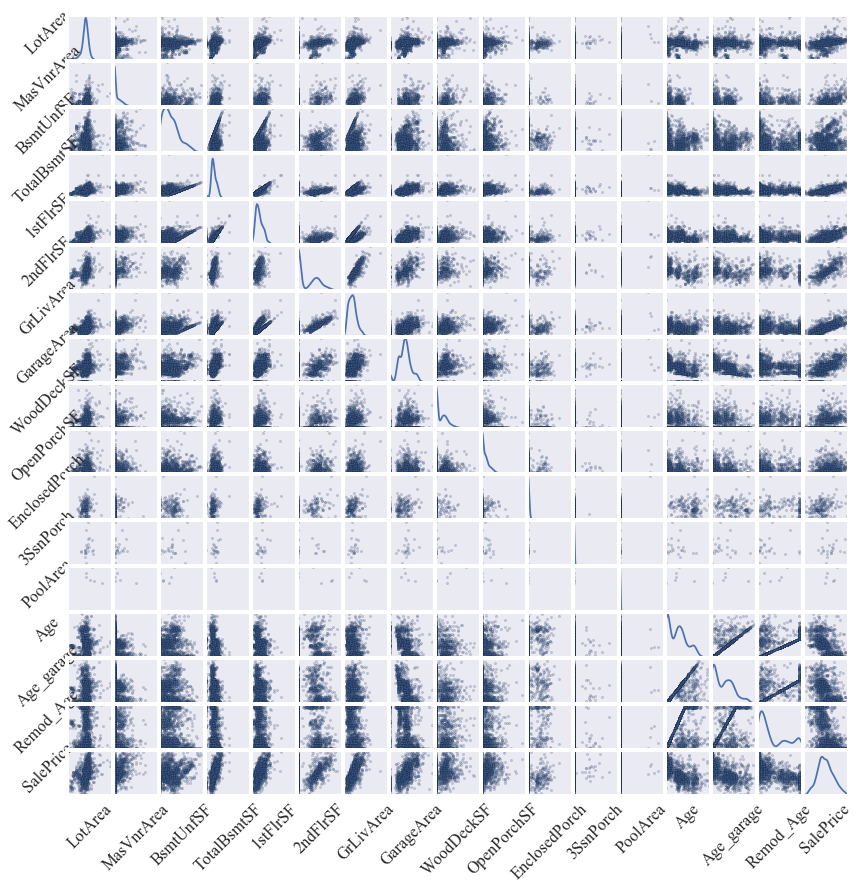

In [233]:
sm = pd.scatter_matrix(data_continuous, alpha = 0.3, figsize = (14,14), diagonal = 'kde');
#Change label rotation
a = [s.xaxis.label.set_rotation(45) for s in sm.reshape(-1)]
a = [s.yaxis.label.set_rotation(45) for s in sm.reshape(-1)]

#May need to offset label when rotating to prevent overlap of figure
a = [s.get_yaxis().set_label_coords(-0.3,0.5) for s in sm.reshape(-1)]

#Hide all ticks
a = [s.set_xticks(()) for s in sm.reshape(-1)]
a = [s.set_yticks(()) for s in sm.reshape(-1)]


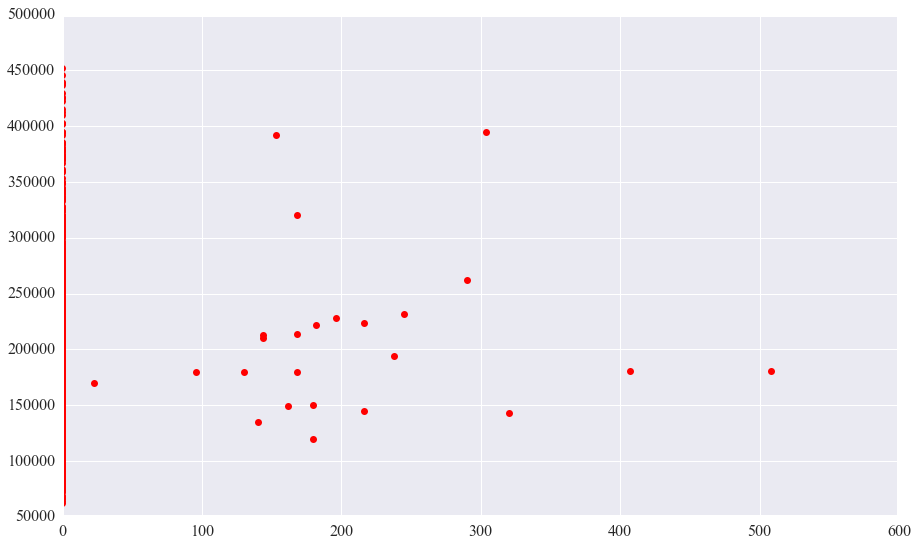

In [236]:
## u'
plt.plot(data_continuous['3SsnPorch'], 10**data_continuous.SalePrice, 'ro')
#plt.xlim(0,2000)

                  Results: Weigthed least squares
Model:              WLS              Adj. R-squared:     0.347     
Dependent Variable: SalePrice        AIC:                -1818.3456
Date:               2016-09-16 17:25 BIC:                -1807.8120
No. Observations:   1432             Log-Likelihood:     911.17    
Df Model:           1                F-statistic:        759.9     
Df Residuals:       1430             Prob (F-statistic): 1.66e-134 
R-squared:          0.347            Scale:              0.016423  
---------------------------------------------------------------------
           Coef.    Std.Err.       t       P>|t|     [0.025    0.975]
---------------------------------------------------------------------
const      5.3358     0.0053   1003.0642   0.0000    5.3254    5.3462
Age       -0.0031     0.0001    -27.5655   0.0000   -0.0033   -0.0029
-------------------------------------------------------------------
Omnibus:              61.716        Durbin-Watson:      

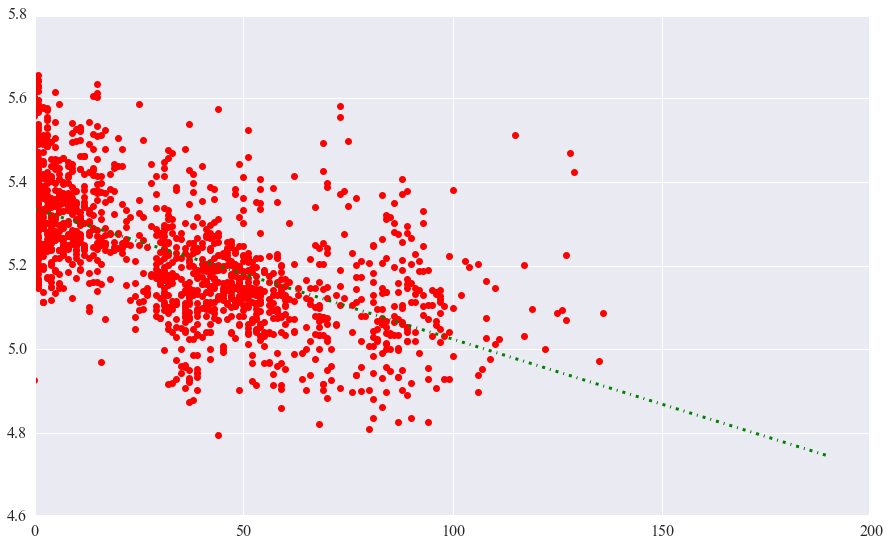

In [215]:
# Remove other features that are not correlated with the HOME value. 
plt.plot(data_continuous.Age, data_continuous.SalePrice, 'ro')


import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

## Fit a line through these points.
model = sm.WLS(data_continuous['SalePrice'], sm.add_constant(data_continuous.Age))
fitted = model.fit()
sdev, lower, upper = wls_prediction_std(fitted)
x = np.arange(0, 200, 10)
plt.plot(x, fitted.params[0] + x*fitted.params[1], 'g-.', linewidth=3)
print fitted.summary2()
#plt.xlim(0,5e3)